### IMPORT

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision.utils import make_grid

In [2]:
sys.path.append(os.path.abspath('..'))

from src.forward_diffusion import forward_diffusion_sample
from src.data_loader import create_dataloader
from src.save_load_model import load_model_img_gen
from src.backward_diffusion import sample

### FUNCTIONS

In [3]:
def double_grid_plot(batch1, batch2, nrow=2, title="?"):
    grid1 = make_grid(batch1, nrow=nrow, normalize=True, pad_value=1)
    grid2 = make_grid(batch2, nrow=nrow, normalize=True, pad_value=1)

    np_grid1 = grid1.permute(1, 2, 0).cpu().numpy()
    np_grid2 = grid2.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(8, 4))  
    
    plt.suptitle(title, fontsize=12, y=0.95) 

    plt.subplot(1, 2, 1)
    plt.imshow(np_grid1, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np_grid2, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()



In [4]:
def conditioned_img_gen(data_loader, model, diffusion_vars, noise_steps, denoise_steps, timesteps, nrow):
    
    device = next(model.parameters()).device

    print(f"noise_steps = {noise_steps}")
    print(f"denoise_steps = {denoise_steps}")
    print(f"timesteps = {timesteps}")
    print("==========================")
    print(device)    
    print("==========================")
    
    original_batch = next(iter(data_loader)).to(device)

    # Add noise to the original images
    noisy_batch, _ = forward_diffusion_sample(original_batch, t=noise_steps, diffusion_variables=diffusion_vars)
    print(f"original imgs range: {torch.min(original_batch)} - {torch.max(original_batch)}")
    print(f"noisy_imgs range: {torch.min(noisy_batch):.3f} - {torch.max(noisy_batch):.3f}")
    
    # Plot using the normalized version
    double_grid_plot(original_batch, noisy_batch, nrow=nrow, 
                     title=f"noise_steps = {noise_steps} | denoise_steps = 0")

    denoise_batches = []
    
    # Denoise the images for each specified step
    for step in denoise_steps:
        title = f"noise_steps = {noise_steps} | denoise_steps = {step}"
        
        # Perform denoising
        denoised = sample(model, noisy_batch.shape, timesteps, diffusion_vars, noisy_batch, step)
        print(f"denoised imgs range: {torch.min(denoised[-1]):.3f} - {torch.max(denoised[-1]):.3f}")
        
        # visualize final denoised image
        denoise_batches.append(denoised[-1])
        double_grid_plot(original_batch, denoised[-1], nrow=nrow, title = title)
    
    return denoise_batches, original_batch, noisy_batch



### DATA LOADING 

In [5]:
# simulated data
file_name = 'SCD_RawBP-mini.h5'
key = 'vc_BP'

# input images location
oadat_dir = 'C:/Users/carlo/OADAT'

### PARAMETERS

In [6]:
batch_size = 4
nrow = 2  
model_name = 'Cosine_05'

#  scaleclip [-0.2,1], norm1_scaleclip [-1,1], norm2_scaleclip [0,1] !!!!
norm_params = {"norm": 'norm1_scaleclip'}

denoise_steps = [400]
noise_steps = 200


In [7]:
prng = np.random.RandomState(42)
dataloader = create_dataloader(oadat_dir, file_name, key, norm_params['norm'], batch_size, 
                               shuffle=False, num_workers=0, prng=prng, indices=None)

### Backward

In [8]:
# model location
model_path = f'../results/models/{model_name}/{model_name}.pth'
# +++

In [9]:
model, config_params, diffusion_vars = load_model_img_gen(model_path)

timesteps = config_params['timesteps']
print(timesteps)

1000


noise_steps = 200
denoise_steps = [400]
timesteps = 1000
cuda:0
original imgs range: -1.0 - 1.0
noisy_imgs range: -1.838 - 1.557


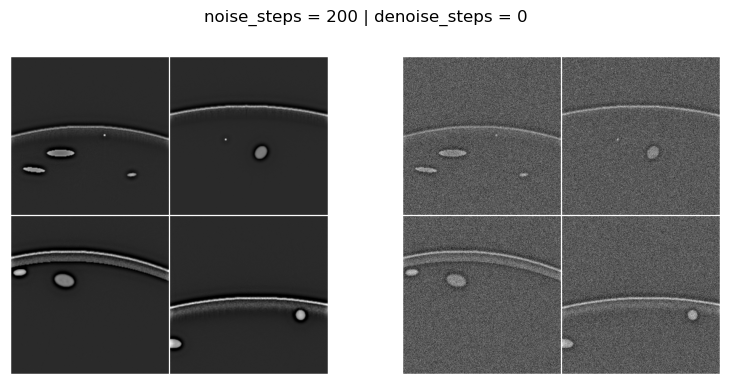

denoised imgs range: -1.068 - 1.132


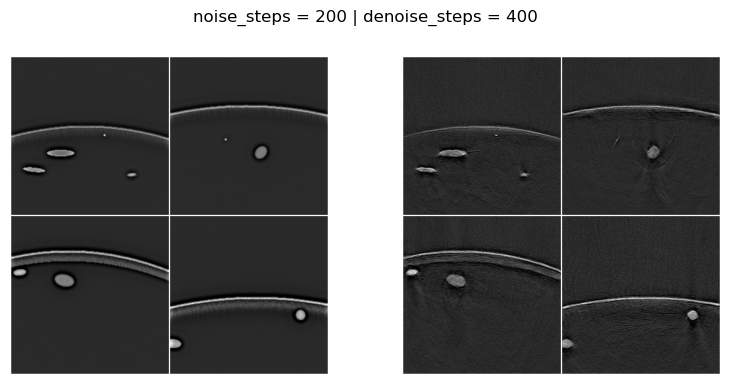

In [10]:
denoise_batches, original_batch, noisy_batch = conditioned_img_gen(
    dataloader, model, diffusion_vars, noise_steps, denoise_steps, timesteps, nrow
)
